In [69]:
#Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

In [70]:
#As urls com os dados
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [71]:
#leitura dos dados
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [72]:
#criando banco de dados
engine = create_engine('sqlite:///:memory:')

In [73]:
#Adcionando tabelas ao banco de dados
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
produtos.to_sql('produtos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [74]:
#Verificação das tabelas do banco de dados
inspect = inspect(engine)
print(inspect.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


In [75]:
#Criando query para consulta
query = 'SELECT CONDICAO FROM PRODUTOS'

In [76]:
#Consultas das condições dos produtos vendidos
with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [77]:
#Criando uma função para armazenar a consulta das condições
def sql_df(query):
    with engine.connect() as conexao:
        consulta = conexao.execute(text(query))
        dados = consulta.fetchall()
    return pd.DataFrame(dados, columns=consulta.keys())

In [78]:
#Criando uma nova query com agrupamento de frequência
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS 
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


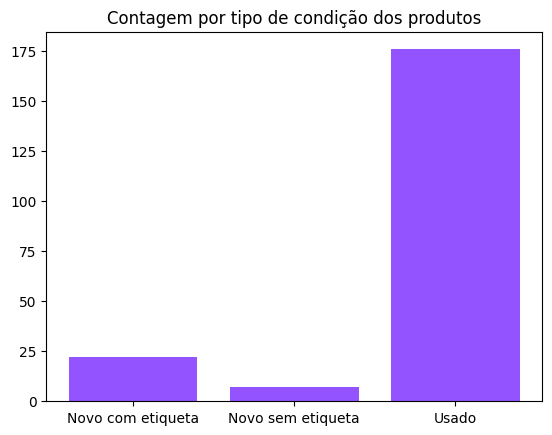

In [79]:
#Plotando um gráfico com as condição acima
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF')
plt.title('Contagem por tipo de condição dos produtos')
plt.show()

In [80]:
#Criando uma relacionamento entre tabelas para demotrar quais e quantos produtos foram vendidos
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [81]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [82]:
#Notando que o relacionamento entre as tabelas é dada na coluna ['pedido_id'] criaremos a query para a demostração
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_qunt = sql_df(query)
df_prod_qunt

,produto_id,produto,Quantidade
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,11218,Calca Alfaiataria Preta,750
198,72667,Saia Pregas Preta,751
199,98640,Calca Jeans Costuras,755


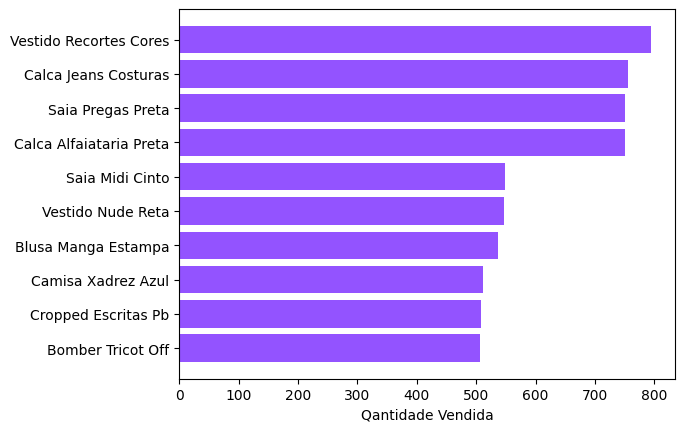

In [83]:
#Vizualição dos produtos mais vendidos
plt.barh(df_prod_qunt['produto'][-10:], df_prod_qunt['Quantidade'][-10:], color='#9353FF')
plt.xlabel('Qantidade Vendida')
plt.show()

In [85]:
#Verificando a tabela PEDIDOS
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [87]:
#Verificando as informações da tabela PEDIDOS
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


In [93]:
#Criando uma query para selecionar as vendas de cada vendendor fez no ano de 2020, mesmo que a data_compra esteja com um tipo "object"
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
'''
sql_df(query)

,nome_vendedor,Quantidade vendas
0,Ana Duarte,3427
1,Daniel Siqueira,3338
2,Nadia Oliveira,2782
3,Millena Pereira,2510
4,Paulo Calanca,2488


In [92]:
#Agora o valor médio de vendas para cada vendedor em 2020
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y',data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


In [94]:
#Aqui estão quais estados que obtiveram mais vendas
query = '''SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''
sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


In [97]:
#E quais vendedores vendem mais em SP 
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157
